In [1]:
import mysql.connector
import json
with open("db_config.json", "r") as fp:
    db_config = json.load(fp)
    db_config.update({"raise_on_warnings": True})

In [2]:
def sql_query(q, extract_single=False) -> list:
    print("Making query to database: \n" + q)
    cnx = mysql.connector.connect(**db_config)
    cnx.connect()
    cursor = cnx.cursor()
    cursor.execute(q)
    res = list(cursor)
    cnx.close()
    print(f"Returning #{len(res)} many entries.")
    if extract_single:
        res = [r[0] for r in res]
    return res


In [3]:
table_name = "SimpleModels_MPSPDZ"

In [4]:
try:
    _ = list(cursor)
except:
    pass

In [5]:
query = f"DESCRIBE {table_name}"
schema = sql_query(query)
schema

Making query to database: 
DESCRIBE SimpleModels_MPSPDZ
Returning #23 many entries.


[('experiment_id', 'int(10)', 'NO', 'PRI', None, 'auto_increment'),
 ('scenario', 'varchar(500)', 'NO', '', None, ''),
 ('target', 'varchar(500)', 'NO', '', None, ''),
 ('protocol', 'varchar(500)', 'NO', '', None, ''),
 ('world_size', 'int(11)', 'NO', '', None, ''),
 ('batch_size', 'int(11)', 'NO', '', None, ''),
 ('tc_delay', 'int(11)', 'NO', '', None, ''),
 ('tc_rate', 'int(11)', 'NO', '', None, ''),
 ('cpus', 'int(2)', 'NO', '', None, ''),
 ('memory_max', 'int(6)', 'NO', '', None, ''),
 ('time_created', 'timestamp', 'NO', '', 'CURRENT_TIMESTAMP', ''),
 ('host', 'varchar(255)', 'YES', '', None, ''),
 ('executor', 'varchar(100)', 'YES', '', None, ''),
 ('time_started', 'timestamp', 'YES', '', None, ''),
 ('acc', 'float', 'YES', '', None, ''),
 ('loss', 'float', 'YES', '', None, ''),
 ('inference_time_s', 'float', 'YES', '', None, ''),
 ('transmitted_bytes', 'bigint(20)', 'YES', '', None, ''),
 ('transmitted_packets', 'bigint(20)', 'YES', '', None, ''),
 ('measurement_start_time_ms', '

In [6]:
import pandas as pd
def res_to_db(col_names: list[str], result: list):
    columns = {}
    for col_i, col in enumerate(col_names):
        columns[col] = []
        for entry in result:
#             print(f"selecting {col_i} from entry {entry}")
            try:
                columns[col].append(entry[col_i])
            except IndexError:
                raise IndexError(f"selecting {col_i} from entry {entry}")
    return pd.DataFrame(data=columns)

In [7]:
import pandas as pd
table_name = None
def dump_to_df() -> pd.DataFrame:
    global table_name
    assert table_name
    query = f"DESCRIBE {table_name}"
    schema = sql_query(query)
    query = ("SELECT *"
            f" FROM `{table_name}`"
            )
    all_entries = sql_query(query)
    return res_to_db([col[0] for col in schema], all_entries)

def select_query_to_df(columns, query, format_query=False):
    if format_query:
        query = query.format(*columns)
    entries = sql_query(query)
#     print(entries)
    return res_to_db(columns, entries)
    

In [8]:
table_name = "SimpleModels_MPSPDZ"

In [9]:
df = dump_to_df()

Making query to database: 
DESCRIBE SimpleModels_MPSPDZ
Returning #23 many entries.
Making query to database: 
SELECT * FROM `SimpleModels_MPSPDZ`
Returning #321 many entries.


In [10]:
select_query_to_df(["batch_size", "inference_time_s"],format_query=True,
                  query=("SELECT {0}, {1}"
                  f" FROM {table_name}"
                  " WHERE protocol='replicated-ring-party.x'"
                  " AND scenario='SimpleLogisticReg'"
                  " ORDER BY {0}"))

Making query to database: 
SELECT batch_size, inference_time_s FROM SimpleModels_MPSPDZ WHERE protocol='replicated-ring-party.x' AND scenario='SimpleLogisticReg' ORDER BY batch_size
Returning #3 many entries.


,batch_size,inference_time_s
0,1,0.005443
1,50,0.000704
2,500,0.000506


In [11]:
a = ("SELECT {0}, {1}"
  f" FROM {table_name}"
  " WHERE protocol=`replicated-ring-party.x`"
  " AND scenario=`SimpleLogisticReg`"
  " ORDER BY {0}".format("a", "b"))
a

'SELECT a, b FROM SimpleModels_MPSPDZ WHERE protocol=`replicated-ring-party.x` AND scenario=`SimpleLogisticReg` ORDER BY a'

In [12]:
try:
    df = df.drop(columns=["cpus", "memory_max", "host", "executor", "measurement_start_time_ms", "compressed_packet_stats", "exception"])
except KeyError:
    pass

In [13]:
df.describe()

,experiment_id,world_size,batch_size,tc_delay,tc_rate,acc,loss,inference_time_s,transmitted_bytes,transmitted_packets
count,321.000000,321.000000,321.000000,321.0,321.0,321.000000,321.0,321.000000,3.210000e+02,3.210000e+02
mean,295.894081,3.099688,183.514019,-1.0,-1.0,0.961227,-1.0,0.786836,1.113279e+11,3.632911e+06
std,203.265670,0.726313,225.032388,0.0,0.0,0.006828,0.0,1.080121,2.368404e+11,6.475255e+06
min,1.000000,2.000000,1.000000,-1.0,-1.0,0.954000,-1.0,0.000506,7.529131e+07,1.064800e+04
25%,140.000000,3.000000,1.000000,-1.0,-1.0,0.954000,-1.0,0.014215,1.273731e+09,2.158100e+05
50%,259.000000,3.000000,50.000000,-1.0,-1.0,0.968000,-1.0,0.232659,7.211575e+09,8.779660e+05
75%,377.000000,4.000000,500.000000,-1.0,-1.0,0.968000,-1.0,1.305160,8.270773e+10,3.544383e+06
max,675.000000,4.000000,500.000000,-1.0,-1.0,0.968000,-1.0,5.228910,1.185264e+12,3.518042e+07


In [14]:
df1 = df.loc[lambda df_: df_['scenario'] == "SimpleLogisticReg"]

In [15]:
  df1["inference_time_s"]

3      0.005443
5      0.000704
7      0.015261
8      0.012471
11     0.012908
         ...   
315    0.000786
316    0.116242
318    0.000592
319    0.001040
320    0.000704
Name: inference_time_s, Length: 160, dtype: float64

In [16]:
df1["batch_size"]

3        1
5       50
7        1
8       50
11       1
      ... 
315     50
316    500
318    500
319     50
320    500
Name: batch_size, Length: 160, dtype: int64

In [17]:
protocols = sql_query("SELECT distinct protocol"
        f" FROM {table_name}",
             extract_single=True)
scenario = "SimpleFFNN"



Making query to database: 
SELECT distinct protocol FROM SimpleModels_MPSPDZ
Returning #27 many entries.


In [18]:

def select_batch_inference_time(proto, ws):
    _df = select_query_to_df(["batch_size", "inference_time_s"],format_query=True,
                      query=("SELECT {0}, {1}"
                      f" FROM {table_name}"
                      f" WHERE protocol='{proto}'"
                      f" AND scenario='{scenario}'"
                      f" AND world_size={ws}"
                      " ORDER BY {0}"))
    bs = _df["batch_size"].to_numpy("int", copy=True)
    time_ = _df["inference_time_s"].to_numpy("float32", copy=True)
    return bs, time_

    

In [19]:
select_batch_inference_time("mascot-party.x", 2)
select_batch_inference_time('replicated-ring-party.x', 3)

Making query to database: 
SELECT batch_size, inference_time_s FROM SimpleModels_MPSPDZ WHERE protocol='mascot-party.x' AND scenario='SimpleFFNN' AND world_size=2 ORDER BY batch_size
Returning #3 many entries.
Making query to database: 
SELECT batch_size, inference_time_s FROM SimpleModels_MPSPDZ WHERE protocol='replicated-ring-party.x' AND scenario='SimpleFFNN' AND world_size=3 ORDER BY batch_size
Returning #3 many entries.


(array([  1,  50, 500]),
 array([0.0061982 , 0.00091527, 0.00064694], dtype=float32))

In [20]:

data_ = []
for proto in protocols:
    world_sizes = sql_query("SELECT distinct world_size"
        f" FROM {table_name}"
        f" WHERE protocol='{proto}'",
             extract_single=True)
    for ws in world_sizes:
        bs, time_ = select_batch_inference_time(proto, ws)
        data_.append((proto, ws, bs, time_))


Making query to database: 
SELECT distinct world_size FROM SimpleModels_MPSPDZ WHERE protocol='replicated-ring-party.x'
Returning #1 many entries.
Making query to database: 
SELECT batch_size, inference_time_s FROM SimpleModels_MPSPDZ WHERE protocol='replicated-ring-party.x' AND scenario='SimpleFFNN' AND world_size=3 ORDER BY batch_size
Returning #3 many entries.
Making query to database: 
SELECT distinct world_size FROM SimpleModels_MPSPDZ WHERE protocol='brain-party.x'
Returning #1 many entries.
Making query to database: 
SELECT batch_size, inference_time_s FROM SimpleModels_MPSPDZ WHERE protocol='brain-party.x' AND scenario='SimpleFFNN' AND world_size=3 ORDER BY batch_size
Returning #3 many entries.
Making query to database: 
SELECT distinct world_size FROM SimpleModels_MPSPDZ WHERE protocol='ps-rep-ring-party.x'
Returning #1 many entries.
Making query to database: 
SELECT batch_size, inference_time_s FROM SimpleModels_MPSPDZ WHERE protocol='ps-rep-ring-party.x' AND scenario='Simple

Returning #3 many entries.
Making query to database: 
SELECT distinct world_size FROM SimpleModels_MPSPDZ WHERE protocol='cowgear-party.x'
Returning #3 many entries.
Making query to database: 
SELECT batch_size, inference_time_s FROM SimpleModels_MPSPDZ WHERE protocol='cowgear-party.x' AND scenario='SimpleFFNN' AND world_size=2 ORDER BY batch_size
Returning #3 many entries.
Making query to database: 
SELECT batch_size, inference_time_s FROM SimpleModels_MPSPDZ WHERE protocol='cowgear-party.x' AND scenario='SimpleFFNN' AND world_size=3 ORDER BY batch_size
Returning #3 many entries.
Making query to database: 
SELECT batch_size, inference_time_s FROM SimpleModels_MPSPDZ WHERE protocol='cowgear-party.x' AND scenario='SimpleFFNN' AND world_size=4 ORDER BY batch_size
Returning #3 many entries.
Making query to database: 
SELECT distinct world_size FROM SimpleModels_MPSPDZ WHERE protocol='chaigear-party.x'
Returning #3 many entries.
Making query to database: 
SELECT batch_size, inference_time_

In [21]:
data_[0:3]

[('replicated-ring-party.x',
  3,
  array([  1,  50, 500]),
  array([0.0061982 , 0.00091527, 0.00064694], dtype=float32)),
 ('brain-party.x',
  3,
  array([  1,  50, 500]),
  array([0.0207767, 0.0179961, 0.0166494], dtype=float32)),
 ('ps-rep-ring-party.x',
  3,
  array([  1,  50, 500]),
  array([0.0175443, 0.0134007, 0.011906 ], dtype=float32))]

In [22]:
import matplotlib.pyplot as plt
import numpy as np


def reset_style(inline_default_rc = dict(plt.rcParams), default_rc = dict(plt.rcParamsDefault)):
    plt.rcParams.update(inline_default_rc)



Matplotlib created a temporary config/cache directory at /tmp/matplotlib-ivo6th8w because the default path (/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


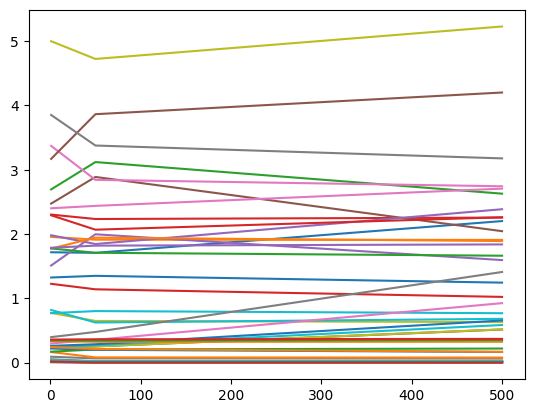

In [23]:
fig, ax = plt.subplots()

for d in data_:
    proto, ws, bs, time_ = d
    ax.plot(bs, time_, label=f"{proto} {ws}")

fig.show()

In [24]:
def label_creator(d):
    return f"{d[0]} {d[1]}"

In [25]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [26]:

        
speedup_labels = []
batch_speed_up = {1: [], 50:[], 500:[]}
base_bs = 1
for d in data_:
    proto, ws, bs, times = d
    try:
        bs = bs.tolist()
    except:
        pass
    
    if any(b not in bs for b in batch_speed_up.keys()):
        print("Not all batch sizes defined for " + proto)
        continue
    
    def time_of_bs(b):
        return times[bs.index(b)]
    
    
    speedup_labels.append(label_creator(d))
    
    base_speed = time_of_bs(base_bs)
    
    for b in batch_speed_up.keys():
        speed_up = 1.0
        if b != base_bs:
            speed_up = base_speed / time_of_bs(b)
        batch_speed_up[b].append(speed_up)
        

Not all batch sizes defined for temi-party.x


In [27]:
df = pd.DataFrame(data=batch_speed_up, index=speedup_labels)
df = df.sort_values(by=[500, 50])


In [51]:
def barplot_batch_size_speedup(df):
#     reset_style()
#     plt.style.use("seaborn-whitegrid")
    
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()

    col_offset = -width/2
    x = np.arange(df.shape[0])
    for bs in df.columns:
        if bs == 1:
            continue
        rec = ax.barh(x+col_offset, df[bs], width, label=str(bs))
        col_offset += width


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Speed up over batch size=1')
#     ax.set_title('Difference in inference speed with varying batch sizes.')
    ax.set_yticks(x, df.index)
#     ax.vlines([1.0], 0, 1, colors="r", linestyles="dashed", label="1 (base line)",
#               transform=ax.get_xaxis_transform(),)
    ax.axvline(1, 0, 1, c="r", linestyle="dashed", label="1 (base line)")
    ax.legend(loc='lower right', framealpha=1.0)
    plt.show()


In [43]:
# barplot_batch_size_speedup(df[:100])

In [44]:
df.describe()

,1,50,500
count,53.0,53.000000,53.000000
mean,1.0,1.744199,1.904106
std,0.0,1.754042,2.248095
min,1.0,0.756362,0.280792
25%,1.0,0.981889,0.971001
50%,1.0,1.108375,1.210082
75%,1.0,1.442876,1.523286
max,1.0,9.018295,11.653362


In [45]:
slowed_down = (df[[50, 500]] < 1.0).any(axis=1)
sped_up = (df[[50, 500]] >= 2.0).all(axis=1)
same_speed = pd.DataFrame((slowed_down == False, sped_up == False)).transpose().all(axis=1)

In [46]:
df1 = pd.DataFrame((slowed_down, same_speed, sped_up)).transpose()
df1["xor"] = (df1[0] ^ df1[1] ^ df1[2])
df1.filter(df1["xor"] == False, axis=0)

,0,1,2,xor


In [53]:
reset_style()
plt.style.use("seaborn-whitegrid")

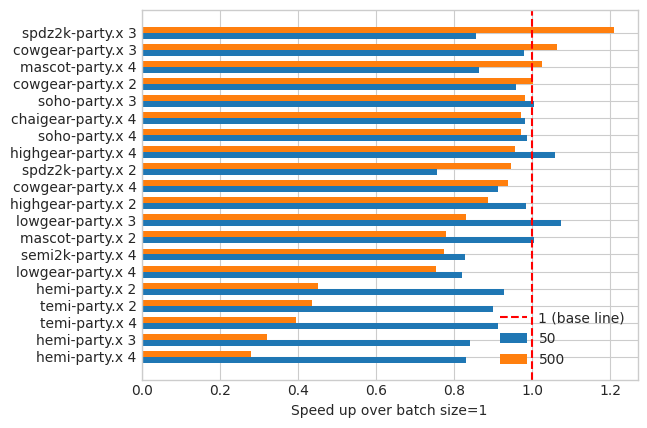

In [54]:
barplot_batch_size_speedup( df[slowed_down])

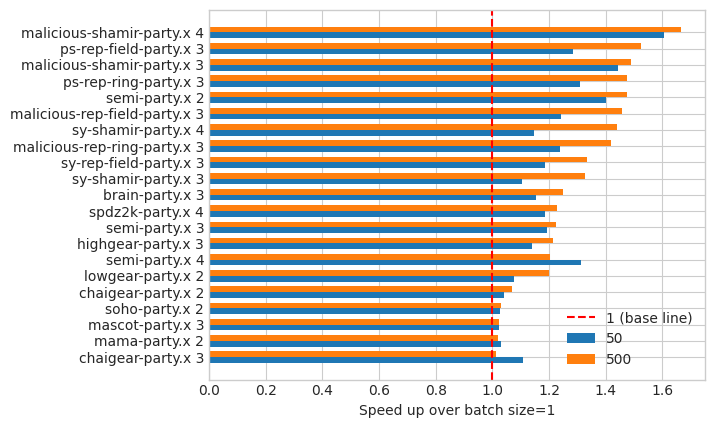

In [55]:
barplot_batch_size_speedup( df[same_speed])

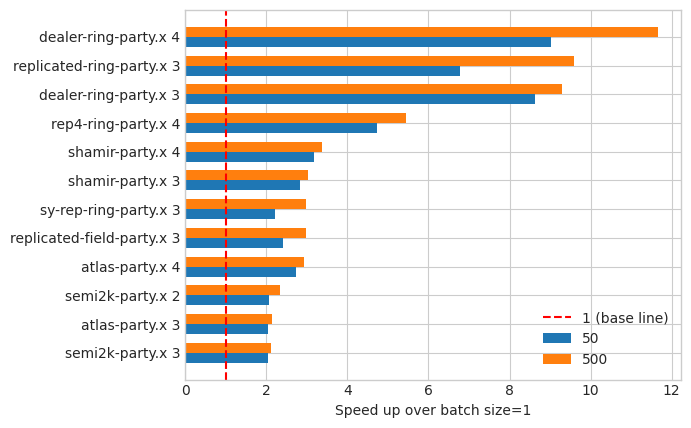

In [56]:
barplot_batch_size_speedup(df[sped_up])

In [57]:
# reset_style()
# for style in plt.style.available:
#     plt.style.use(style)
#     print("Using style: " + style)
#     barplot_batch_size_speedup(df[sped_up])
#     reset_style()


## Inference time of batch size = 1

In [59]:
labels = []
batch_times = {1:[], 50:[], 500:[]}

for d in data_:
    proto, ws, bs, times = d
    try:
        bs = bs.tolist()
    except:
        pass
    if any(b not in bs for b in batch_speed_up.keys()):
        print("Not all batch sizes defined for " + proto)
    
    def time_of_bs(b):
        if b in bs:
            return times[bs.index(b)]
        else:
            return float("nan")
    labels.append(label_creator(d))
    for b in batch_times.keys():
        batch_times[b].append(time_of_bs(b))
            

Not all batch sizes defined for temi-party.x


In [60]:
df = pd.DataFrame(data=batch_times, index=labels)
df.head()


,1,50,500
replicated-ring-party.x 3,0.006198,0.000915,0.000647
brain-party.x 3,0.020777,0.017996,0.016649
ps-rep-ring-party.x 3,0.017544,0.013401,0.011906
malicious-rep-ring-party.x 3,0.017495,0.014126,0.012341
sy-rep-ring-party.x 3,0.011502,0.005166,0.003856


In [61]:
df = df.sort_values(by=1, ascending=False)

In [92]:
def barplot_inference_time(df):
#     plt.style.use('default')
#     plt.style.use("seaborn-whitegrid")
    width = 0.5  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_figheight(10)
#     col_offset = -width/2
    x = np.arange(df.shape[0])
#     rec = ax.barh(x, df[500], width)
#     rec = ax.barh(x, df[50], width)

    rec = ax.barh(x, df[1], width)
#         col_offset += width


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Inference time [sec] for each sample batch size=1')
    ax.set_ylabel('Protocol name and number of parties')
#     ax.set_title('Difference in inference speed with varying batch sizes.')
    ax.set_yticks(x, df.index)
    ax.set_xscale('log')
#     ax.vlines([1.0], 0, 1, colors="r", linestyles="dashed", label="1 (base line)",
#               transform=ax.get_xaxis_transform(),)
#     ax.axvline(1, 0, 1, c="r", linestyle="dashed", label="1 (base line)")
#     ax.legend(loc='lower right')
    plt.show()


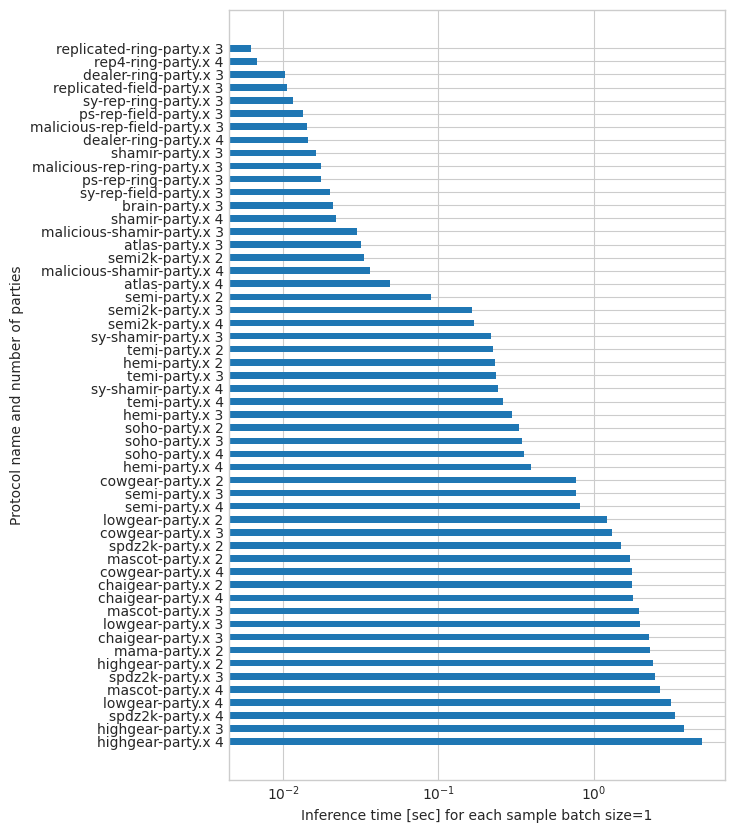

In [93]:
barplot_inference_time(df)

# Speed up based on player count